In [1]:
import pyspark
sc = pyspark.SparkContext("local[3]")

In [2]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *

dataset = datasetGenerator()
dataset.addGenerator(idGenerator(),prefix="line",min=1,max=5,keyName="lineId")
dataset.addGenerator(idGenerator(),prefix="item",min=1,max=15,keyName="itemId")
dataset.addGenerator(tickGenerator(),minTick=600,maxTick=1800,keyName="creationDate")
dataset.addGenerator(intGenerator(),keyName="qty")

logRdd = sc.parallelize( dataset.generateDataset(25000)).persist()

## Exercise (1): Similar statistics but on item,line couple

In [3]:
logRdd.first()

{'lineId': 'line_02',
 'itemId': 'item_009',
 'creationDate': datetime.datetime(2010, 1, 1, 0, 24, 53),
 'qty': 762}

In [4]:
def add(x,y): 
    return x+y

## How many lines per item,line

In [5]:
def extractItemLine(x):
    return (x.get("itemId"), x.get("lineId"))

In [6]:
logRdd.map(extractItemLine).map(lambda x: (x,1)).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).take(5)

[(('item_014', 'line_03'), 363),
 (('item_001', 'line_01'), 361),
 (('item_012', 'line_04'), 359),
 (('item_009', 'line_01'), 358),
 (('item_005', 'line_02'), 356)]

## How much qty per item,line

In [7]:
def extractItemLineWithQty(x):
    return ((x.get("itemId"), x.get("lineId")), x.get("qty"))

In [8]:
logRdd.map(extractItemLineWithQty).reduceByKey(add).sortBy(lambda x: x[1], ascending=False).take(5)

[(('item_001', 'line_01'), 192119),
 (('item_010', 'line_05'), 188694),
 (('item_005', 'line_02'), 185394),
 (('item_006', 'line_02'), 183599),
 (('item_010', 'line_04'), 183505)]

## How much qty in average per item,line

In [9]:
def extractItemLineWithQtyAndCounter(x):
    return ((x.get("itemId"), x.get("lineId")),(x.get("qty"), 1))

def sumWithCounter(x,y): 
    return x[0]+y[0], x[1]+y[1]

def calculateAvg(x):
    return x[0], x[1][0]/x[1][1]

In [10]:
logRdd.map(extractItemLineWithQtyAndCounter)\
    .reduceByKey(sumWithCounter).map(calculateAvg)\
    .sortBy(lambda x: x[1], ascending=False)\
    .take(5)

[(('item_006', 'line_02'), 546.4255952380952),
 (('item_002', 'line_01'), 537.7341772151899),
 (('item_010', 'line_01'), 536.5424242424242),
 (('item_001', 'line_01'), 532.185595567867),
 (('item_010', 'line_04'), 531.8985507246376)]

# Exercise (2): why if we count, we see fewer items?

In [11]:
semiLogRdd = logRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")),x)).persist()
semiLogRdd.count()

25000

In [12]:
semiLogRdd.first()

(('line_02', 'item_009'),
 {'lineId': 'line_02',
  'itemId': 'item_009',
  'creationDate': datetime.datetime(2010, 1, 1, 0, 24, 53),
  'qty': 762})

In [13]:
joinedRDD = semiLogRdd.join(semiLogRdd).persist()
joinedRDD.count()

8356098

In [14]:
joinedRDD.first()

(('line_05', 'item_008'),
 ({'lineId': 'line_05',
   'itemId': 'item_008',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 50, 44),
   'qty': 629},
  {'lineId': 'line_05',
   'itemId': 'item_008',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 50, 44),
   'qty': 629}))

In [15]:
# we take only values with creationDate of left side lesser than creatioDate of right one
triangleJoinedRdd = joinedRDD.filter(lambda x: x[1][0].get("creationDate")<x[1][1].get("creationDate")).persist()
triangleJoinedRdd.count()

4165549

In [16]:
triangleJoinedRdd.first()

(('line_05', 'item_008'),
 ({'lineId': 'line_05',
   'itemId': 'item_008',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 50, 44),
   'qty': 629},
  {'lineId': 'line_05',
   'itemId': 'item_008',
   'creationDate': datetime.datetime(2010, 1, 1, 20, 42, 24),
   'qty': 571}))

The schema is:

**k: Key, v1: Value, v2: Value**
    
Where:

* **Key : string, string**
* **Value: {'lineId': string, 'itemId': string, 'creationDate': date, 'qty': int}**

In [17]:
def extractItemLineWithCreationData(x):
    key,value = x
    left,right = value
    new_key = key,left.get("creationDate")
    new_value = right.get("creationDate") - left.get("creationDate"), value
    return new_key,new_value

In [18]:
# for each (item,line) we compute a new entry with 
#   key: old_key, creationDate of left
#   value: deltaTime between left and side, old_value
triangleJoinedRdd.map(extractItemLineWithCreationData).first()

((('line_05', 'item_008'), datetime.datetime(2010, 1, 1, 1, 50, 44)),
 (datetime.timedelta(seconds=67900),
  ({'lineId': 'line_05',
    'itemId': 'item_008',
    'creationDate': datetime.datetime(2010, 1, 1, 1, 50, 44),
    'qty': 629},
   {'lineId': 'line_05',
    'itemId': 'item_008',
    'creationDate': datetime.datetime(2010, 1, 1, 20, 42, 24),
    'qty': 571})))

In [19]:
def compareDeltaTime(x,y):
    return x if x[0]<y[0] else y

def extractLeftItemLine(x):
    key,value = x
    deltaTime,(left,right) = value
    left["cycleTime"] = deltaTime
    return left
    
enrichedLogRdd = triangleJoinedRdd.map(extractItemLineWithCreationData)\
                    .reduceByKey(compareDeltaTime)\
                    .map(extractLeftItemLine)\
                    .persist()
enrichedLogRdd.first()

{'lineId': 'line_05',
 'itemId': 'item_008',
 'creationDate': datetime.datetime(2010, 1, 1, 20, 42, 24),
 'qty': 571,
 'cycleTime': datetime.timedelta(seconds=41483)}

## Solution

We see fewer items because we apply the function `reduceByKey`

In [20]:
enrichedLogRdd.count()

24925

This number, obviously, is equal to the number of distinct key!!

In [21]:
triangleJoinedRdd.map(extractItemLineWithCreationData)\
    .map(lambda x: x[0])\
    .distinct()\
    .count()

24925

Applying the `reduceKey` function the result that we obtain is essentialy: **For each item that was produced by a line at a certain creationDate we take the immediately after time when this item is produced by the same line**.

Without applying the `reduceKey` function we have all possible combination so the number is bigger.


Just for example if we have a smaller dataset:

In [22]:
smallDataset = datasetGenerator()
smallDataset.addGenerator(idGenerator(),prefix="line",min=1,max=1,keyName="lineId")
smallDataset.addGenerator(idGenerator(),prefix="item",min=1,max=1,keyName="itemId")
smallDataset.addGenerator(tickGenerator(),minTick=600,maxTick=1800,keyName="creationDate")

smallLogRdd = sc.parallelize(smallDataset.generateDataset(4))\
    .map(lambda x: ((x.get("lineId"),x.get("itemId")),x))\
    .persist()

smallLogRdd.collect()

[(('line_01', 'item_01'),
  {'lineId': 'line_01',
   'itemId': 'item_01',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 22, 17)}),
 (('line_01', 'item_01'),
  {'lineId': 'line_01',
   'itemId': 'item_01',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 40, 39)}),
 (('line_01', 'item_01'),
  {'lineId': 'line_01',
   'itemId': 'item_01',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 55, 48)}),
 (('line_01', 'item_01'),
  {'lineId': 'line_01',
   'itemId': 'item_01',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 59, 44)})]

In [23]:
smallJoinedRdd = smallLogRdd.join(smallLogRdd)
smallJoinedRdd.count()

16

With $4$ entry with the same key if we apply `join` function we obtain $16$ entries because is like a Cartesian Product

In [24]:
smallTriangleJoinedRdd = smallJoinedRdd.filter(lambda x: x[1][0].get("creationDate")<x[1][1].get("creationDate"))\
    .persist()
smallTriangleJoinedRdd.count()

6

In [25]:
smallEnrichedLogRdd = smallTriangleJoinedRdd.map(extractItemLineWithCreationData)\
                    .reduceByKey(compareDeltaTime)\
                    .map(extractLeftItemLine)
smallEnrichedLogRdd.collect()

[{'lineId': 'line_01',
  'itemId': 'item_01',
  'creationDate': datetime.datetime(2010, 1, 1, 0, 55, 48),
  'cycleTime': datetime.timedelta(seconds=236)},
 {'lineId': 'line_01',
  'itemId': 'item_01',
  'creationDate': datetime.datetime(2010, 1, 1, 0, 40, 39),
  'cycleTime': datetime.timedelta(seconds=909)},
 {'lineId': 'line_01',
  'itemId': 'item_01',
  'creationDate': datetime.datetime(2010, 1, 1, 0, 22, 17),
  'cycleTime': datetime.timedelta(seconds=1102)}]

In [26]:
smallEnrichedLogRdd.count()

3

We started with $4$ entries and we obtain only $3$ entries because we lost the last *log data* produced since is filtered => of course there is no entry that has a creationDate bigger than the last data produced!!

# Exercise (3): I want to see the histogram of cycle times

In [27]:
data = enrichedLogRdd.map(lambda x: x["cycleTime"].seconds).collect()

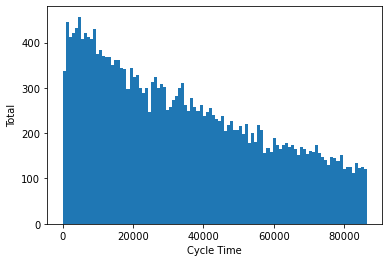

In [28]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(data, bins=100)  
plt.ylabel('Total')
plt.xlabel('Cycle Time');
plt.show()